# Diabetes prediction: gradient boosting

## Notebook set-up

This notebook implements **Gradient Boosting** - a sequential ensemble method that builds trees iteratively, with each new tree correcting errors from previous ones. We import `HistGradientBoostingClassifier` (scikit-learn's modern, efficient implementation) and wait for the Random Forest notebook to complete first.

In [1]:
# Python standard library imports
import os
import pickle
import time
from pathlib import Path

# PyPI imports - data manipulation and visualization
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

# PyPI imports - statistical and machine learning libraries
from scipy.stats import randint, uniform, loguniform
from sklearn.compose import ColumnTransformer
from sklearn.impute import KNNImputer
from sklearn.ensemble import HistGradientBoostingClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import cross_val_score, RandomizedSearchCV
from sklearn.pipeline import Pipeline

# Internal imports - project-specific modules
import configuration as config
import functions as funcs

# Wait for the random forest notebook to finish execution
while True:
    if os.path.exists(config.RANDOM_FOREST_MODEL):
        break

    else:
        time.sleep(5)

## 1. Data loading

### 1.1. Load data from disk

We continue using the same preprocessed dataset for consistency across all algorithm comparisons. This ensures any performance differences are due to the algorithms themselves, not data preprocessing variations.

In [2]:
# Load the preprocessed dataset that was saved from the decision tree notebook
with open(config.DATA_FILE, 'rb') as input_file:
    dataset = pickle.load(input_file)

# Extract training and testing dataframes from the loaded dictionary
training_df = dataset['training']
testing_df = dataset['testing']

### 1.2. Inspect

Quick verification of the loaded dataset structure and contents.

In [3]:
training_df.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
725,4,112,78,40,0,39.4,0.236,38,0
66,0,109,88,30,0,32.5,0.855,38,1
175,8,179,72,42,130,32.7,0.719,36,1
1,1,85,66,29,0,26.6,0.351,31,0
209,7,184,84,33,0,35.5,0.355,41,1


## 2. Model training

### 2.1. Previous scores

We now implement Gradient Boosting, which differs from Random Forest by building trees sequentially rather than in parallel. Each new tree focuses on correcting the mistakes of previous trees, potentially leading to superior performance but with higher risk of overfitting.

In [4]:
# Load cross validation scores from previous models
with open(config.CROSS_VAL_SCORES_FILE, 'rb') as input_file:
    cross_val_scores = pickle.load(input_file)

Load the comprehensive performance results from all previous models (logistic regression, decision tree variants, Random Forest variants) to maintain our complete algorithm comparison database.

### 2.2. Gradient boosting model

Gradient Boosting builds an ensemble by sequentially adding weak learners (typically small trees) that correct the errors of previous models. Key characteristics:

- **Sequential learning**: Each tree learns from previous trees' mistakes
- **Error correction**: New trees focus on hard-to-predict samples
- **Typically superior performance**: Often outperforms Random Forest
- **Higher overfitting risk**: Sequential learning can memorize training data
- **Slower training**: Cannot parallelize tree construction like Random Forest

We use `HistGradientBoostingClassifier` for its efficiency and modern optimizations.

In [5]:
# Load the list of features to impute
with open(config.IMPUTED_FEATURES_FILE, 'rb') as input_file:
    imputed_features = pickle.load(input_file)

# Create the imputer
knn_imputer = ColumnTransformer([('imputer', KNNImputer(), imputed_features)], remainder='passthrough')

# Create a gradient boosting classifier with default hyperparameters
tree_model = HistGradientBoostingClassifier(
    class_weight=config.CLASS_WEIGHT,
    random_state=config.RANDOM_SEED
)

naive_model = Pipeline(
    steps=[
        ('KNN', knn_imputer),
        ('classifier', tree_model)
    ]
)

# Train the naive gradient boosting model
naive_model.fit(training_df.drop('Outcome', axis=1), training_df['Outcome'])

# Calculate and display training accuracy
accuracy = accuracy_score(naive_model.predict(training_df.drop('Outcome', axis=1)), training_df['Outcome'])*100
print(f'Training accuracy of gradient boosting model: {accuracy:.1f}%')

Training accuracy of gradient boosting model: 99.5%


Cross-validation is especially important for Gradient Boosting to detect overfitting. We expect to see:
- **Potentially higher average performance**: Gradient boosting often achieves the best results
- **Possible higher variance**: Sequential learning can be sensitive to training data
- **Training vs validation gap**: Important to monitor for overfitting

In [6]:
# Perform cross-validation on the naive gradient boosting model
scores = cross_val_score(
    naive_model,
    training_df.drop('Outcome', axis=1),
    training_df['Outcome'],
    cv=config.CROSS_VAL,
    n_jobs=-1                   # Use all available CPU cores for parallel processing
)

# Store results for comparison with previous models and future optimized model
cross_val_scores['Model'].extend(['Gradient boosting']*len(scores))
cross_val_scores['Score'].extend(scores*100)

# Display cross-validation results with mean and standard deviation
print(f'Cross-validation accuracy: {np.mean(scores)*100:.1f} +/- {np.std(scores)*100:.1f}%')

Cross-validation accuracy: 72.9 +/- 1.6%


## 3. Hyperparameter optimization

### 3.1. Hyperparameter search

Gradient Boosting hyperparameter optimization includes unique parameters not found in Random Forest:

- **Learning rate**: Controls how much each new tree contributes (lower = more conservative)
- **Max iterations**: Number of sequential trees to build
- **Regularization**: L2 penalty to prevent overfitting
- **Histogram binning**: Efficiency optimization for continuous features
- **Interaction constraints**: Control feature interactions between trees

Proper tuning is crucial for Gradient Boosting to achieve optimal performance without overfitting.

In [7]:
%%time

# Define hyperparameter search space for gradient boosting optimization
hyperparameters = {
    'KNN__imputer__n_neighbors': randint(1, 3),
    'KNN__imputer__weights': ['uniform', 'distance'],
    'KNN__imputer__add_indicator': [True, False],
    'classifier__learning_rate': loguniform(10**-5, 1.0),
    'classifier__max_iter': randint(2, 200),
    'classifier__max_leaf_nodes':randint(2, 1000),
    'classifier__max_depth':randint(1, 20),
    'classifier__min_samples_leaf': randint(1, 20),
    'classifier__l2_regularization': loguniform(10**-5, 1.0),
    'classifier__max_features':uniform(loc=0.1, scale=0.9),
    'classifier__max_bins': randint(10, 255),
    'classifier__interaction_cst': ['pairwise', 'no_interactions'],
}

# Perform randomized search over hyperparameters
search = RandomizedSearchCV(
    naive_model,
    hyperparameters,
    return_train_score=True,                 # Return training scores for analysis
    cv=config.CROSS_VAL,                     # Use stratified shuffle split for cross-validation
    n_jobs=-1,                               # Use all available CPU cores
    n_iter=config.RANDOM_SEARCH_ITERATIONS,  # Number of parameter combinations to try
    random_state=config.RANDOM_SEED          # Ensure reproducible results
)

# Fit the search and extract best model and parameters
search_results = search.fit(training_df.drop('Outcome', axis=1), training_df['Outcome'])
best_model = search_results.best_estimator_
winning_hyperparameters = search_results.best_params_

# Display the best hyperparameters found
print('Best hyperparameters:\n')

for key, value in search_results.best_params_.items():
    print(f' {key}: {value}')

print()

print(f'Run time ({os.cpu_count()} CPUs):\n')

Best hyperparameters:

 KNN__imputer__add_indicator: False
 KNN__imputer__n_neighbors: 1
 KNN__imputer__weights: distance
 classifier__interaction_cst: no_interactions
 classifier__l2_regularization: 0.0006536117572826347
 classifier__learning_rate: 0.017923195771453022
 classifier__max_bins: 169
 classifier__max_depth: 2
 classifier__max_features: 0.34843272658938773
 classifier__max_iter: 178
 classifier__max_leaf_nodes: 595
 classifier__min_samples_leaf: 11

Run time (20 CPUs):

CPU times: user 3h 30min 17s, sys: 2min 27s, total: 3h 32min 44s
Wall time: 3h 36min 29s


### 3.2. Hyperparameter optimization results

We visualize the hyperparameter search results to understand how much hyperparameters matter and whether we found good solutions.

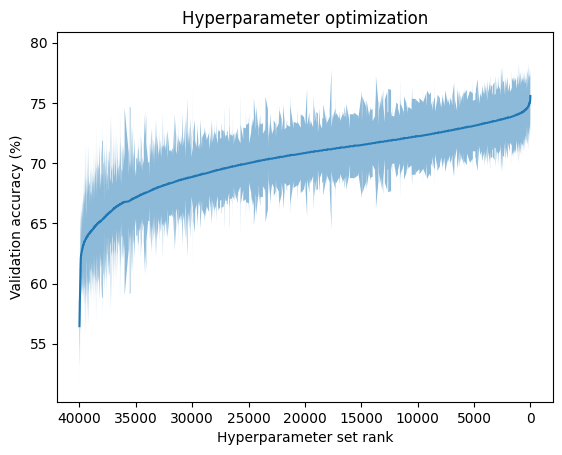

In [8]:
funcs.plot_cross_validation(search_results)

### 3.3. Cross-validation of optimized model

Evaluating the optimized Gradient Boosting model will show whether hyperparameter tuning successfully improved performance while avoiding overfitting. This comparison completes our tree-based algorithm evaluation.

In [9]:
# Perform cross-validation on the optimized gradient boosting model
scores = cross_val_score(
    best_model,
    training_df.drop('Outcome', axis=1),
    training_df['Outcome'],
    cv=config.CROSS_VAL,
    n_jobs=-1                   # Use all available CPU cores for parallel processing
)

# Store results for comparison with all other models
cross_val_scores['Model'].extend(['Optimized gradient boosting']*len(scores))
cross_val_scores['Score'].extend(scores*100)

# Display cross-validation results for the optimized gradient boosting model
print(f'Cross-validation accuracy: {np.mean(scores)*100:.1f} +/- {np.std(scores)*100:.1f}%')

Cross-validation accuracy: 75.6 +/- 1.9%


## 4. Evaluation

### 4.1. Cross-validation performance

Final evaluation will determine if Gradient Boosting achieves the best performance among all tested algorithms. We'll compare against the logistic regression baseline and examine whether the sequential ensemble approach provides advantages over the parallel Random Forest approach.

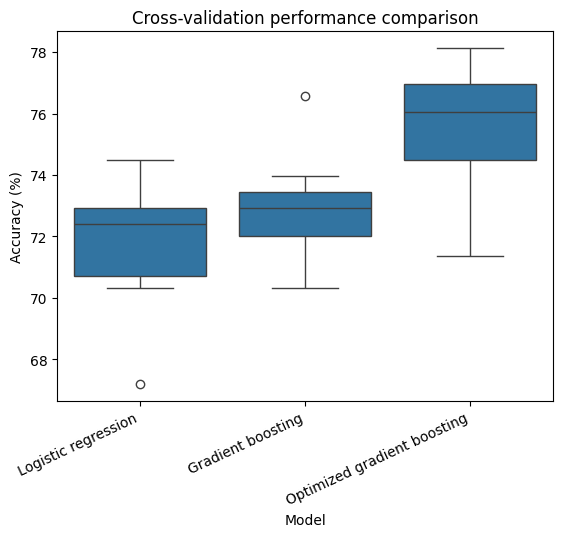

In [10]:
# Create boxplot to compare cross-validation performance
models = ['Logistic regression', 'Gradient boosting', 'Optimized gradient boosting']
plot_scores = pd.DataFrame.from_dict(cross_val_scores)
plot_scores = plot_scores[plot_scores['Model'].isin(models)]

sns.boxplot(plot_scores, x='Model', y='Score')
plt.title('Cross-validation performance comparison')
plt.ylabel('Accuracy (%)')
plt.xticks(rotation=25, ha='right')  # Rotate x-axis labels for better readability
plt.show()

Focused comparison showing the progression from linear model to basic Gradient Boosting to optimized Gradient Boosting, highlighting the impact of the sequential ensemble method and hyperparameter tuning.

### 4.2. Test set performance

The ultimate test: how do our Gradient Boosting models perform on completely unseen data? The confusion matrices will reveal:
- **Sequential vs parallel ensemble**: Gradient Boosting vs Random Forest performance
- **Overfitting assessment**: Whether optimization led to better generalization
- **Clinical relevance**: How well each model identifies diabetic patients in practice

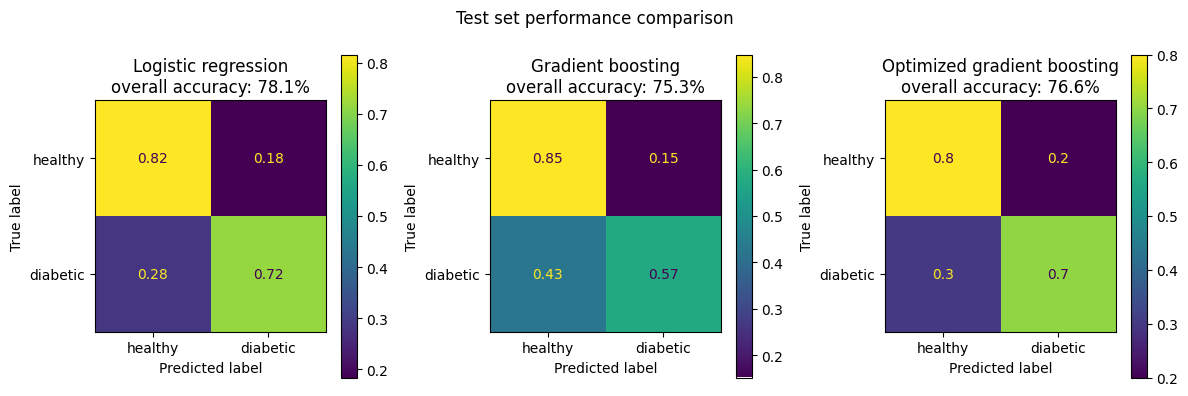

In [11]:
# Retrain both naive and optimized gradient boosting models on the full training set
result = naive_model.fit(training_df.drop('Outcome', axis=1), training_df['Outcome'])
result = best_model.fit(training_df.drop('Outcome', axis=1), training_df['Outcome'])

# Load the logistic regression model for comparison
with open(config.LOGISTIC_REGRESSION_MODEL, 'rb') as input_file:
    linear_model = pickle.load(input_file)

# Generate confusion matrices for both gradient boosting models on the test set
funcs.plot_confusion_matrices(
    models = {
        'Logistic regression': linear_model,
        'Gradient boosting': naive_model,
        'Optimized gradient boosting': best_model
    },
    testing_df=testing_df
)

## 6. Save

### 6.1. Cross-validation scores

We save the final Gradient Boosting results to complete our comprehensive algorithm comparison database, preserving all model performances for the ultimate project evaluation and potential deployment of the best-performing model.

In [12]:
with open(config.CROSS_VAL_SCORES_FILE, 'wb') as output_file:
    pickle.dump(cross_val_scores, output_file)

Final update to our cross-validation scores database with Gradient Boosting results, completing the comprehensive performance comparison across all tested algorithms.

### 6.2. Model

Save the optimized Gradient Boosting model and hyperparameters for:
- **Final comparison**: Loading in other notebooks for comprehensive evaluation
- **Deployment readiness**: The model can be used for production predictions
- **Research reproduction**: Exact configurations can be recreated
- **Documentation**: Complete record of the best-performing sequential ensemble approach

In [13]:
# Save the optimal hyperparameters for future use or reproduction
with open(config.GRADIENT_BOOSTING_HYPERPARAMETERS, 'wb') as output_file:
    pickle.dump(winning_hyperparameters, output_file)

# Save the trained best gradient boosting model for deployment or further analysis
with open(config.GRADIENT_BOOSTING_MODEL, 'wb') as output_file:
    pickle.dump(best_model, output_file)  # Fixed: should be best_model, not model